<h1><center> INF 5520 Mandatory term project 2018 - part II</center></h1>
<h3><center> Feature evaluation and classification</center></h3>
<h1><center> Wonho Lee </center></h1>
<h3><center>wonhol@ifi.uio.no</center></h3>


# Introduction



The goal of this assignment is to implement multivariate gaussian classifier for texture classification by handcrafted features extracted from GLCM analysis of the textures. GLCM analysis is taken further from the previous assignement. However instead of using known feature functions such as IDM, inertia and cluster shade, custom feature function is implemented from careful analysis of GLCM matrices. The report records process of feature selection, implementation of multivariate gaussian classifier, the results of the classification task on the given test data set, then discusses its performance and limitations in the methods.

## 1. Choosing GLCM images to work with

As this report is edited in jupyter notebook, all the code is included and represented in between. First all the given GLCM matrices and training image is visulized by following script.

In [ ]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import glob # for scratching files
from glcm import * # from previous assignement
from numba import jit

In [2]:
# Read in all the images
files = glob.glob('*.txt')
imgs = {}
for file in files:
    f = open(file,'r')
    line = f.readline()
    tmp = []
    while line:
        tmp.append(np.array(line.split(',')).astype(np.int))
        line = f.readline()
        
    tmp = np.array(tmp)
    imgs[file[:-4]] = tmp

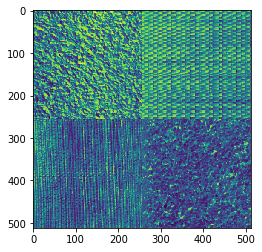

Texture1


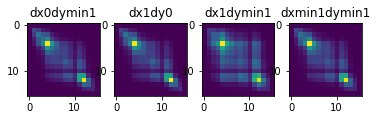

Texture2


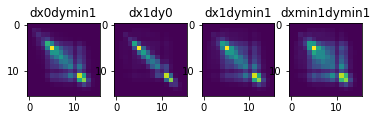

Texture3


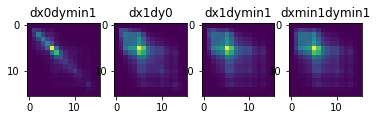

Texture4


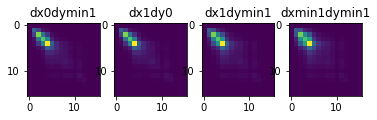

In [3]:
# display GLCM matrices
plt.imshow(imgs['mosaic1_train'])
plt.show()
for i in range(4):
    c = 0
    for n,im in imgs.items():
        if n.startswith('texture%d'%(i+1)):
            plt.subplot(1,4,(c+1))
            plt.title(n[8:])
            plt.imshow(im)
            c += 1
    print('Texture%d'%(i+1))
    plt.show()

At the glance 0 degree seems to distinguish textures best. If it is feasible, combining 90 degree would be most efficient to seperate the textures as both reveals distinctive characteristic of direction oriented texture 2 and 3 from the rest and each other.

## 2. Discussing new features by subdividing the GLCM matrices

As the given GLCM matrices are symmetrical, the proposed feature vector $\vec{Q}=[Q1,Q2,Q3,Q4]$ will end up having same value for $Q2$ and $Q3$. The proposed feature also ignores local distribution of GLCM values as it calculates summed average. This might result in a similar value for two textures despite the obvious difference in its shape. Since most information is focused in the first quadrant, the first quadrant is divided into 4 subquadrant. We call these subquadrants $Q5$, $Q5$ and $Q7$, and they are calculated by

$$Q5=\frac{\sum_{i=1}^{4}\sum_{j=1}^{4}P(i,j)}{\sum_{i=1}^{8}\sum_{j=1}^{8}P(i,j)}$$
$$Q6=\frac{\sum_{i=5}^{8}\sum_{j=1}^{4}P(i,j)}{\sum_{i=1}^{8}\sum_{j=1}^{8}P(i,j)}$$
$$Q7=\frac{\sum_{i=5}^{8}\sum_{j=5}^{8}P(i,j)}{\sum_{i=1}^{8}\sum_{j=1}^{8}P(i,j)}$$

Each subquadrant is visualized with same scalar for each pixel to examine the feasibility of each features.

texture1dx1dy0


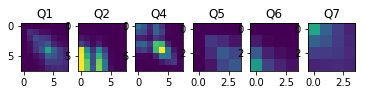

texture2dx1dy0


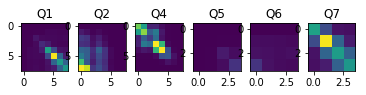

texture3dx1dy0


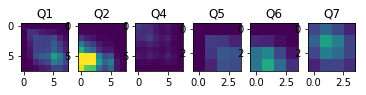

texture4dx1dy0


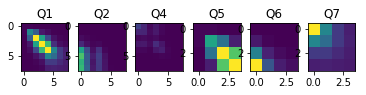

In [4]:
for n,im in imgs.items():
    if 'dx1dy0' in n:
        print(n)
        plt.subplot(161)
        plt.title('Q1')
        plt.imshow(im[:8,:8]).set_clim(vmin=0, vmax=10000)
        plt.subplot(162)
        plt.title('Q2')
        plt.imshow(im[:8,8:]).set_clim(vmin=0, vmax=1000)
        plt.subplot(163)
        plt.title('Q4')
        plt.imshow(im[8:,8:]).set_clim(vmin=0, vmax=5000)
        plt.subplot(164)
        plt.title('Q5')
        plt.imshow(im[:4,:4]).set_clim(vmin=0, vmax=8000)
        plt.subplot(165)
        plt.title('Q6')
        plt.imshow(im[:4,4:8]).set_clim(vmin=0, vmax=5000)
        plt.subplot(166)
        plt.title('Q7')
        plt.imshow(im[4:8,4:8]).set_clim(vmin=0, vmax=10000)
        plt.show()

As each feature is calculated with the energy of the each subquadrant, it is important to look at overall shades of each subquadrants. 

  * $Q1$ It seems that texture 4 will have distinctive value.
  * $Q2$ Texture 1,3 and Texture 2,4 might be able to be seperated with this feature.
  * $Q4$ Texture 1,2 and 3,4 should be distinguished by this feature.
  * $Q5$ Texture 1,3 and 2 and 4 should be able to separated.
  * $Q6$ Texture 2 seems stick out.
  * $Q7$ It is difficult to estimate what resulting feature value would be from visualization.
  
From the observation above, it may be worth to investivate on features $Q2$, $Q4$, $Q5$ and $Q6$, as these features separtates textures from each other or in groups.
  

##  3. Selecting and implementing a subset of these features

With considerations from previous chapters, feature map is calculated for both in horizontal and vertical direction of GLCM and all the features are computed for each GLCM.

In [5]:
# define feature function
def myFeature(glcm):
    denom = np.sum(glcm)
    q1 = np.sum(glcm[:8,:8])
    q2 = np.sum(glcm[:8,8:16])/denom
    q4 = np.sum(glcm[8:16,8:16])/denom
    
    # sub-quadrant of q1
    q5 = np.sum(glcm[:4,:4])/q1
    q6 = np.sum(glcm[:4,4:8])/q1
    q7 = np.sum(glcm[4:8,4:8])/q1
    
    q1 = q1/denom
    
    return (q1,q2,q4,q5,q6,q7)

In [6]:
# calculate feature map
featureMap = slidingWindow(quantize(imgs['mosaic1_train']), \
                           1, '0', False, myFeature, numfeat=6)
featureMap90 = slidingWindow(quantize(imgs['mosaic1_train']), \
                             1, '90', False, myFeature, numfeat=6)

Horizontal


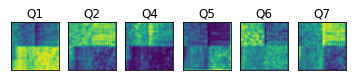

Vertical


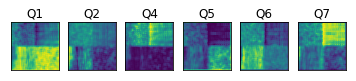

In [7]:
# visualize feature maps
ind = [1,2,4,5,6,7]
print('Horizontal')
for i in range(6):
    plt.subplot(161+i)
    plt.title('Q%d'%(ind[i]))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(featureMap[:,:,i])
plt.show()

print('Vertical')
for i in range(6):
    plt.subplot(161+i)
    plt.title('Q%d'%(ind[i]))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(featureMap90[:,:,i])
plt.show()

From the feature maps, it appears that some of the features are correlated to certain degree. For example, feature $Q1$,$Q2$ and $Q4$ seems to separate texture 1,2 and texture 3,4 fairly well. It might not be necessary to include all three features into the classification task. Feature $Q5$ and $Q7$ seems to be negatively correlated, where the highest and lowest values are inversed to each other. 

While most of features are quite identical from both directions, it is clearly seen that $Q2$ and $Q6$ are distintive between the directions at the same time separating textures fairly well.

Based on these observations, the author propose feature vector of $\vec{Q} = [Q2_h,Q6_h,Q2_v,Q4_v]$ for classification task.

## 4. Implement a multivariate Gaussian classifier

Multivariate gaussian classifier is implemented as an class object which holds $\mu$ and $\Sigma_s$. Then prosterier probability is calculated with log expression,

$$g_i(x) = -\frac{1}{2}(x-\mu_i)^T\Sigma^{-1}(x-\mu_i) - \frac{d}{2}\log{2\pi} - \frac{1}{2}\log{|\Sigma_i|} + \log{p(\omega_i})$$

Where $d$ is number of classes and $P(\omega_i)$ prior probability, which assuemd to be 1 in this case. Implementing log probability may reduce failure occuring due to floating point error. 

Computation of mean vector, $\mu$ and covariance matrix, $\Sigma_s$ is done via function provided in Numpy package. One thing to note about the built in covariance function in Numpy implements sample covariance matrix. Unbiased covariance matrix computation was achieved by setting parameter `ddof=0`.

The guassian classifier object is then element of container class, classifier. The container class holds gaussian classifier for each classes. The case where each features are independent($\Sigma_s=\sigma^2I$) and exponential posterior probability is also implemented for testing purpose.

In [10]:
class gaussianClassifier():
    @jit
    def __init__(self, inputs,  numVar = 1, diag=False):
        self.numVar = numVar

        self.u = np.mean(inputs,axis=1)
        if diag:
            self.cov = np.cov(inputs,ddof=0)*np.eye(numVar)
        else:
            self.cov = np.cov(inputs,ddof=1)
            
        self.var = np.var(inputs)
    
    @jit
    def classify(self, x, Pw, log=False):
        if self.numVar > 1 :
            exponent = np.matmul(np.matmul(( x - self.u ).transpose(),\
                                            np.linalg.inv( self.cov )), \
                                ( x - self.u ))
            if not log:
                return ( 1 / np.sqrt( (2*np.pi)**self.numVar \
                                     * abs(np.linalg.det( self.cov )) ) \
                        * np.exp( -0.5 * exponent ) )   
            else:
                return ( -0.5 * exponent \
                        - self.numVar/2 * np.log(2*np.pi) \
                        - 0.5 * np.log(np.linalg.det(self.cov)))

        elif self.numVar == 1:
            return (1 / np.sqrt( 2*np.pi*self.var ) \
                    * np.exp(-.5 * (x - self.u)**2 / self.var ) * Pw)

class classifier():
    @jit
    def __init__(self, numClass):
        self.numClass = numClass
        self.gaussian = []

    # trainset MxNxL where M corresponds to each classes, 
    #     and N number of variable, L length of feature vector
    @jit
    def train(self, trainset):
        # for each class
        for i in range(self.numClass):
            # instanciate gaussianCLF
            self.gaussian.append(gaussianClassifier(trainset[i], \
                                                    trainset[i].shape[0]))


    @jit
    def classify(self, feature,log=True):
        prb = []
        for i in range(self.numClass):
            prb.append(self.gaussian[i].classify(feature, 1, log))
        return prb.index(max(prb))

In [11]:
@jit
def classMask(featureMap):
    res = np.zeros([512,512])
    for i in range(res.shape[0]):
        for j in range(res.shape[1]):
            res[i,j] = clf.classify(featureMap[i,j])
    return res

@jit
def validate(result):
    acc = [0,0,0,0]
    result = result.astype(np.uint)
    conf_mat = np.zeros([4,4]).astype(np.uint)
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            if i < result.shape[0]/2:
                if j< result.shape[1]/2:
                    conf_mat[0, result[i,j]] += 1
                    if result[i,j] == 0:
                        acc[0] += 1
                else:
                    conf_mat[1, result[i,j]] += 1
                    if result[i,j] == 1:
                        acc[1] += 1
            else:
                if j< result.shape[1]/2:
                    conf_mat[2, result[i,j]] += 1
                    if result[i,j] == 2:
                        acc[2] += 1
                else:
                    conf_mat[3, result[i,j]] += 1
                    if result[i,j] == 3:
                        acc[3] += 1
    return np.array(acc)/(result.shape[0]/2)**2, conf_mat
            

## 5. Training the classifier based on the feature subset from point 3. 

In [12]:
# redefine feature function with chosen features
def myFeature(glcm):
    denom = np.sum(glcm)
    q1 = np.sum(glcm[:8,:8])
    q2 = np.sum(glcm[:8,8:16])/denom
    
    # sub-quadrant of q1
    q5 = np.sum(glcm[:4,:4])/q1
    q6 = np.sum(glcm[:4,4:8])/q1
    
    return (q2,q6)

In [13]:
# extract feature
featureMap = slidingWindow(quantize(imgs['mosaic1_train']), \
                           1, '0', False, myFeature, numfeat=2)
featureMap90 = slidingWindow(quantize(imgs['mosaic1_train']), \
                             1, '90', False, myFeature, numfeat=2)
featureMap = np.dstack([featureMap,featureMap90])

In [14]:
# Train classifier
feature = []
for i in range(1,5):
    tmp = featureMap[:]
    mask = imgs['training_mask']==i
    tmp = tmp[np.where(mask!=0)].T
    feature.append(tmp)
                   
clf = classifier(4)
clf.train(feature)

In [15]:
# Classify train image
train_res = classMask(featureMap)

acc [0.91563416 0.98561096 0.97131348 0.95422363] 
avg_acc 0.956695556640625
[[60007  2321   423  2785]
 [  905 64593    21    17]
 [  813   901 63656   166]
 [  503   557  1940 62536]]


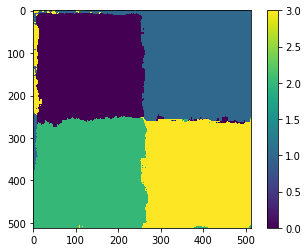

In [16]:
# display results
r,c = validate(train_res)
print('acc',r,'\navg_acc',np.mean(r))
print(c)
plt.imshow(train_res)
plt.colorbar()
plt.show()

The result on the train image seems fairly promissing. It scored 95% average accuracy and even edges seems to have been classifed well despite the smudged edge introduced by zero padding. On this high accuracy, it might be feasible to doubt about overfitting of the model. 



## 6. Evaluation of classification performance on the test data set using the set of features selected in point 3. 

Compute feature map for the mosaic 2 and classify.

In [17]:
testfeatureMap = slidingWindow(quantize(imgs['mosaic2_test']), \
                               1, '0', False, myFeature,numfeat=2)
testfeatureMap90 = slidingWindow(quantize(imgs['mosaic2_test']), \
                                 1, '90', False, myFeature,numfeat=2)
testfeatureMap = np.dstack([testfeatureMap,testfeatureMap90])

In [18]:
res = classMask(testfeatureMap)

acc [0.91880798 0.98777771 0.98472595 0.95533752] 
avg_acc 0.9616622924804688
[[60215  3107   504  1710]
 [  643 64735    74    84]
 [  577     1 64535   423]
 [  767   821  1339 62609]]


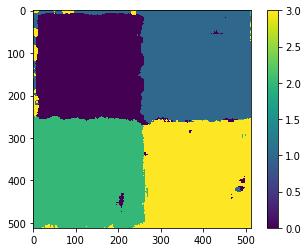

In [19]:
r,c = validate(res)
print('acc',r,'\navg_acc',np.mean(r))
print(c)
plt.imshow(res)
plt.colorbar()
plt.show()

Some tiny misclassified patches are observed, but it scores higher result than train image at 96% average accuracy. Following script computes feature map from mosaic 3 and classifies.

In [20]:
testfeatureMap2 = slidingWindow(quantize(imgs['mosaic3_test']), \
                                1, '0', False, myFeature,numfeat=2)
testfeatureMap290 = slidingWindow(quantize(imgs['mosaic3_test']), \
                                  1, '90', False, myFeature,numfeat=2)
testfeatureMap2 = np.dstack([testfeatureMap2,testfeatureMap290])

In [21]:
res2 = classMask(testfeatureMap2)

acc [0.92193604 0.65170288 0.9238739  0.34825134] 
avg_acc 0.7114410400390625
[[60420  4141   284   691]
 [22820 42710     6     0]
 [ 3151   759 60547  1079]
 [34359  7168  1186 22823]]


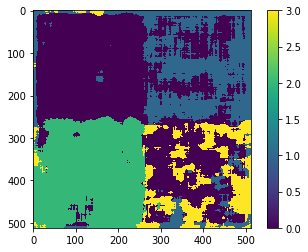

In [22]:
r,c = validate(res2)
print('acc',r,'\navg_acc',np.mean(r))
print(c)
plt.imshow(res2)
plt.colorbar()
plt.show()

The result from mosaic 3 scores average 71%, where texture 1 and 2 is still fairly high at ~92% but texture 2 and 4 are rather dreadful. Texture 4 is most misclassified as texture 1 as seen on the confusion matrix.

# Discussion/Conclusion

The classifier trained on the feature vector, $\vec{Q} = [Q2_h,Q6_h,Q2_v,Q4_v]$ provides good results on train image and mosaic2 despite the slight offset in the direction of texture 2 and 3. However the classifier does not manage the drastic change in graylevel such as in mosaic3. Following figures shows each mosaic images and its histogram of the quantized images.

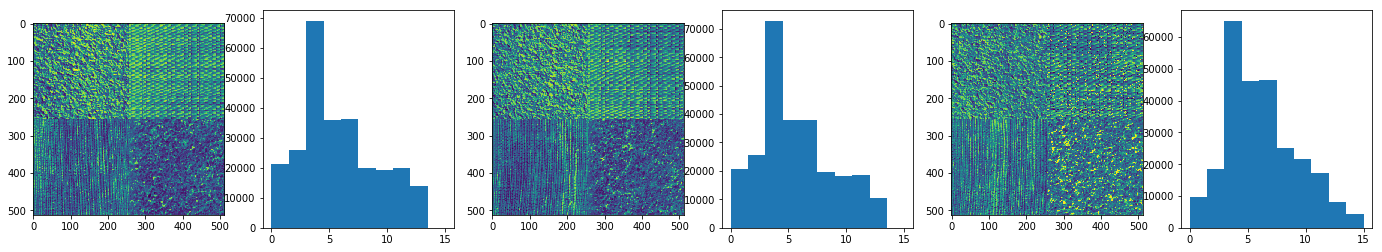

In [23]:
plt.figure(figsize=(24,4))
plt.subplot(161)
plt.imshow(imgs['mosaic1_train'])
plt.subplot(162)
plt.hist(quantize(imgs['mosaic1_train']).flatten())
plt.subplot(163)
plt.imshow(imgs['mosaic2_test'])
plt.subplot(164)
plt.hist(quantize(imgs['mosaic2_test']).flatten())
plt.subplot(165)
plt.imshow(imgs['mosaic3_test'])
plt.subplot(166)
plt.hist(quantize(imgs['mosaic3_test']).flatten())
plt.show()

The singular matrix mentioned in previous chapter appears when same features are introduced in the feature vector for covariance computation. As same features will have same correlation to other features and 1 to itself, two columns in the covariance matrix will be linearly dependant, hence singular matrix.

Having a features that too similar to each other can also lead to a numerical problem as the determinant of the covariance matrix approaches toward zero. Having a too low value for correlation, as in two almost indepandant features can result in numerical error where positive semidefiniteness of symmetrical matrix is violated in computation. This issue seems to be inherent to the library that was used in the implementation - Numpy. Although covariance matrix passes assertion, `assert cov.T == cov`, during the iterative process in determinant calculation, it allows overflow and results in negative determinant, which is mathmetically not possible for a positive semidefinate matrix. 

To go around the numerical issue, the author attempted implementing classifer using $\Sigma_s=\sigma^2I$, and training classifier with train data with all the zero values after masking which would give much higher values for the covariance matrix. Both methods solved overflow issue in computation but both ended up in worse results as the former ignores correlation between features and for the latter increased variances/correlation values interference between features.

The implementation of multivariate gaussian seems to work fairly well with train mosaic and the first test mosaic. As shown on the figure above, it seems that the reason the classifier is struggling with the second test mosaic is the change in graylevel. This may have been resolved to certain degree if preprocessing for normalizing the target image has been done beforehand, as structual information such as direction of texture and texture element size are preserved well from GLCM features.